# Clock Plot Example usage
This notebook provides examples of how to use clock_plot

In [1]:
import pandas as pd
import os
import clock_plot.clock as cp
import plotly.express as px
import clock_plot
import warnings
import os
import urllib.request as urllib2
import json
from datetime import date, datetime
import plotly.io as pio

In [2]:
# Suppress warnings as there is a warning coming from plotly using pd.append rather than pd.concat
warnings.simplefilter(action='ignore', category=FutureWarning)

To get the figures to display on Github we set the renderer to 'png', but this can be set to 'notebook'/'notebook-connected' for interactive figures (or removed entirely). Note that static figures render much more quickly.

In [3]:
pio.renderers.default = 'png'

## Example data 1 - energy usage for a single house
This data is a cleaned version of energy usage for a single house from the Energy System Catapult's Living Lab - full data available [here](https://usmart.io/org/esc/discovery?tags=Living%20Lab).

In [4]:
readings_raw = pd.read_csv(os.path.join(clock_plot.CLOCK_PLOT_DIR, "..", "data", "eden_2_houseid_324_combined_data.csv"))
readings_raw["datetime"] = pd.to_datetime(readings_raw["datetime"])

As is generally the case with Plotly (the package clock_plot is built on), data needs to be in a long format rather than wide in order for grouping to work nicely.

In [5]:
readings = readings_raw.melt( id_vars=["datetime"], value_vars=["reading_elec","reading_gas"])
readings.rename(columns={"variable":"fuel","value":"reading"}, inplace=True)
readings["fuel"] = readings["fuel"].map({"reading_elec":"elec","reading_gas":"gas"})
readings.head()

,datetime,fuel,reading
0,2017-12-08 10:00:00,elec,423.688148
1,2017-12-08 11:00:00,elec,371.261564
2,2017-12-08 12:00:00,elec,448.061277
3,2017-12-08 13:00:00,elec,547.379868
4,2017-12-08 14:00:00,elec,279.790683


### Basic plot
We can start with a basic plot, showing gas usage by season. To do this, we specify the datetime and value columns, filter to fuel='gas' and specify that we want to define color based on season. Note that the colors for season are automatically defined to be relatively intuitive (though these can be overwritten).

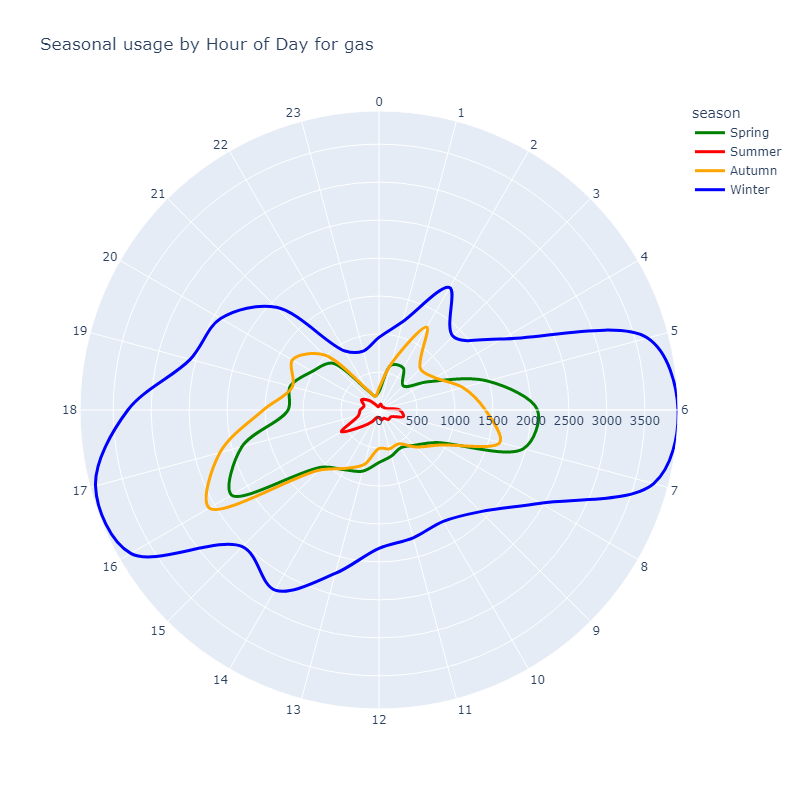

In [6]:
fig = cp.clock_plot(readings, datetime_col='datetime', value_col='reading', 
                    filters={'fuel': 'gas'}, 
                    color='season',
                    title_start='Seasonal usage')

### Advanced filtering and color schemes

Next, we can focus in on summer and winter months. To do this we filter based on season, using a list to specify the two seasons we are interested in, and then color based on month. We then apply a custom color sequence to make it more visually appealing.

We can see that in this example the definition of season works well - winter and summer months have very different usage patterns.

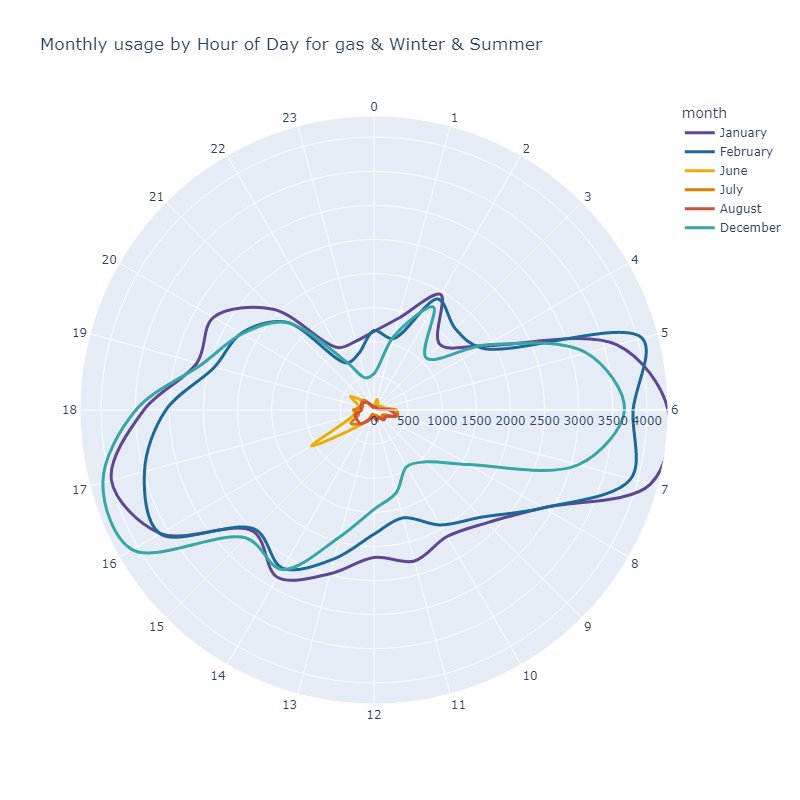

In [7]:
fig = cp.clock_plot(readings, datetime_col='datetime', value_col='reading', 
                    filters={'fuel': 'gas', 
                            'season':['Winter', 'Summer']}, 
                    color='month',
                    color_discrete_sequence=px.colors.qualitative.Prism + [px.colors.qualitative.Prism[2]],
                    title_start='Monthly usage')

### Granular data and averages

The next plot shows how we can look at both granular data and averages on the same plot. For example, we can look at individual weeks within 2018 using line_group='week' and then include an average for the whole year by specifying aggregate={'year':'mean'}. Note that a subtitle is automatically generated explaining that each line represents a single week. Note that we can resize the plot by passing the standard Plotly height and width parameters in.

You can see from the plot that there's a consistent peak at either 7 or 8am, with much more varied usage in the late afternoon/evening that gets smoothed out by the average.

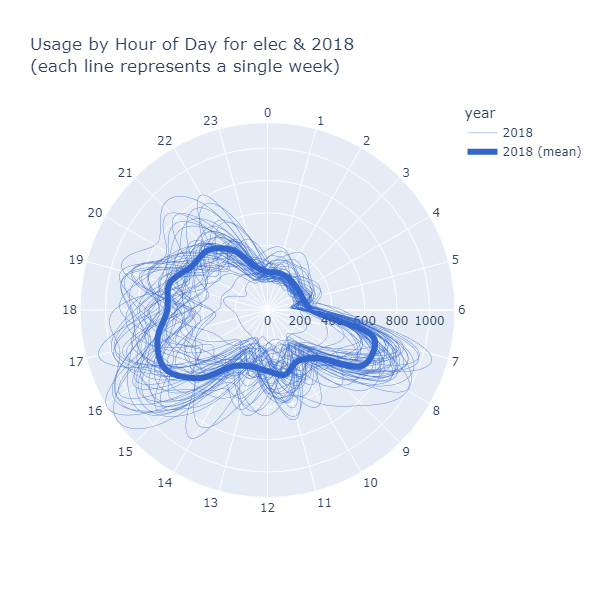

In [8]:
fig = cp.clock_plot(readings, datetime_col='datetime', value_col='reading', 
                    filters={'fuel': 'elec', 'year': 2018}, 
                    color='year',
                    line_group='week',
                    aggregate={'year':'mean'},
                    height=600,
                    width=600,                    
                    title_start='Usage')                    

We hypothesise that much of the variation might occur over the weekend, so we can split by that. If you toggle elements on/off (using the legend when plots are interactive) you can see that the weekend is more variable, but weekdays still do have a lot of variation.

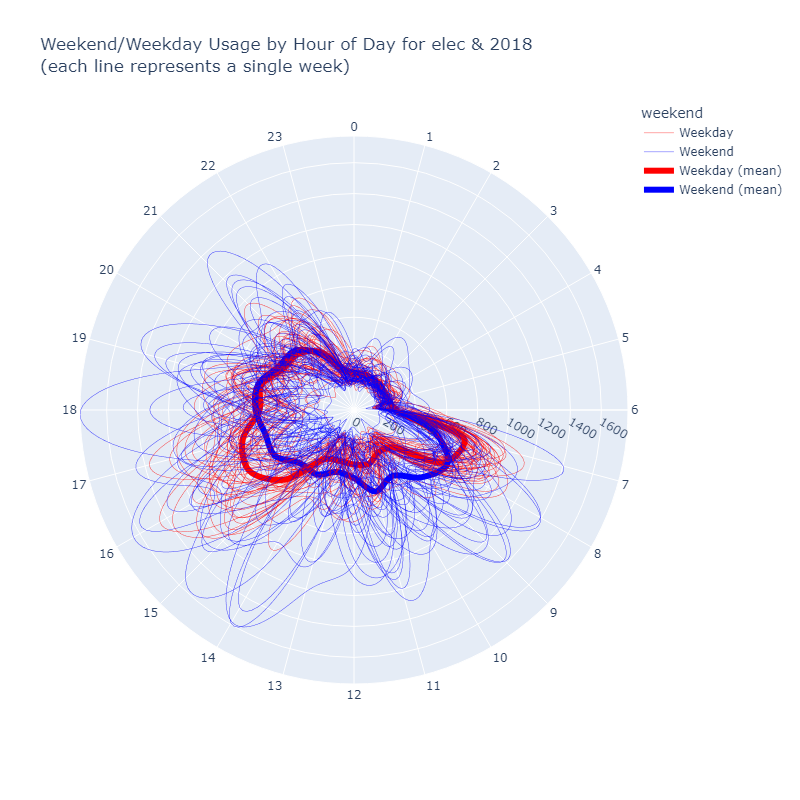

In [9]:
fig = cp.clock_plot(readings, datetime_col='datetime', value_col='reading', 
                    filters={'fuel': 'elec', 'year': 2018}, 
                    color='weekend',
                    line_group='week',
                    aggregate={'weekend':'mean'},
                    color_discrete_sequence=['red', 'blue'],
                    title_start='Weekend/Weekday Usage')

We can break things down even further by plotting a line for each date. We can resize the plot by passing the standard Plotly height and width parameters in. We can also plot a non-smoothed version by specifying line_shape='linear'. Note that we use 'date' for line group here rather than 'day' so that this would generalise if we expanded out to more months (since day is just day of month).

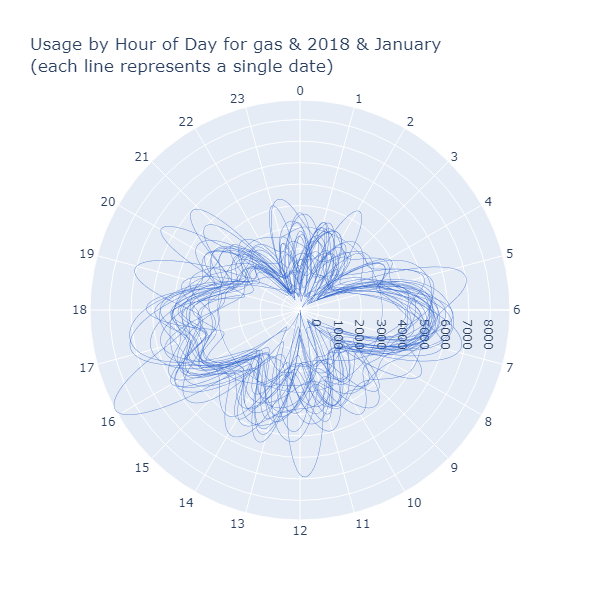

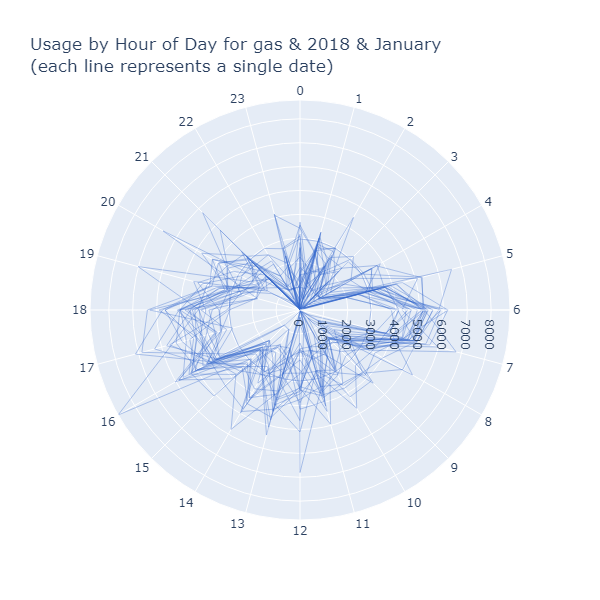

In [10]:
fig = cp.clock_plot(readings, datetime_col='datetime', value_col='reading', 
                    filters={'fuel': 'gas', 'year': 2018, 'month':'January'}, 
                    line_group='date',
                    height=600,
                    width=600,
                    title_start='Usage')
fig = cp.clock_plot(readings, datetime_col='datetime', value_col='reading', 
                    filters={'fuel': 'gas', 'year': 2018, 'month':'January'}, 
                    line_group='date',
                    line_shape='linear',
                    height=600,
                    width=600,
                    title_start='Usage')                    

### Multiple dimensions
As well as defining color, we can use line_dash so we can compare across two dimensions at once. For example, the below plot shows both gas and electricity for 2018 and 2019. It also shows a good example of the type of pattern that might be discoverable using these plots - between 2018 and 2019 the shapes have rotated one hour earlier, suggesting a change in routine for whoever is living in this house.

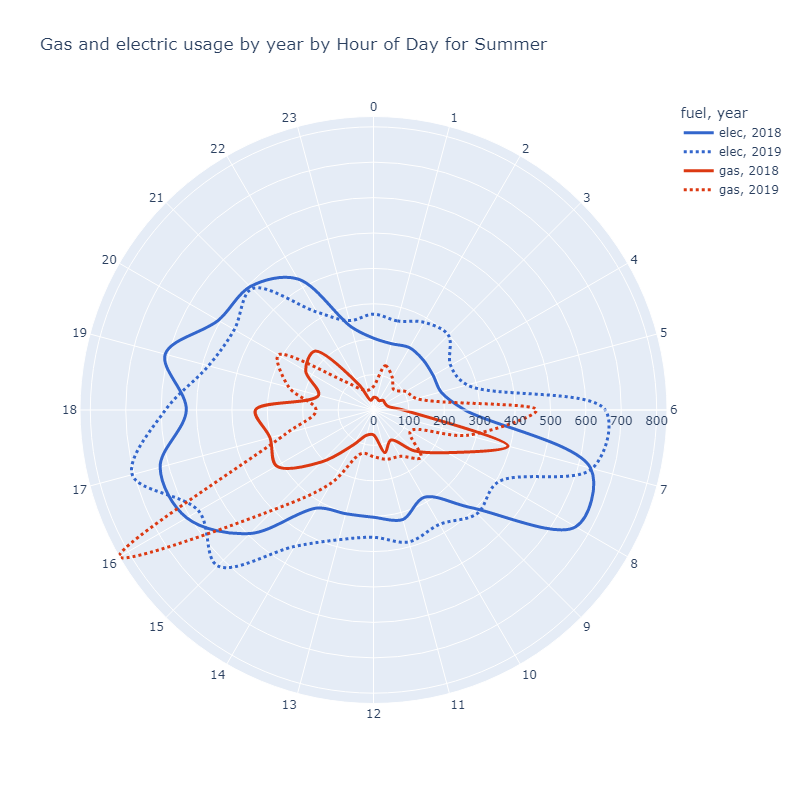

In [11]:
fig = cp.clock_plot(readings, datetime_col="datetime", value_col="reading",
                    filters={"season":"Summer"},
                    color="fuel",
                    line_dash="year",
                    title_start=f'Gas and electric usage by year')

## Dataset 2 - UK Energy mix
This data is from the National Grid Electricity System Operator and looks and which fuels were used to generate the UK's energy (available [here](https://data.nationalgrideso.com/carbon-intensity1/historic-generation-mix))

In [12]:
# Load in Energy Mix Data
n_years_offset = 10
n_offset = 48*365*n_years_offset
n_years = 2
n_rows = 48*365*n_years
url = f"https://data.nationalgrideso.com/api/3/action/datastore_search?resource_id=f93d1835-75bc-43e5-84ad-12472b180a98&limit={n_rows}&offset={n_offset}"
fileobj = urllib2.urlopen(url)
data = fileobj.read()
datadict = json.loads(data.decode('utf-8'))
gen_mix_raw = pd.DataFrame( datadict["result"]["records"] )
gen_mix_raw.head()

,_id,DATETIME,GAS,COAL,NUCLEAR,WIND,HYDRO,IMPORTS,BIOMASS,OTHER,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,175126,2018-12-28T10:30:00,17214,610,6898,7759,619,2878,2300,67,...,7.3,5.9,0.2,1.9,0.4,100,46.7,40.9,23.3,45.4
1,175127,2018-12-28T11:00:00,16881,605,6890,7952,502,2882,2411,69,...,7.3,6.1,0.2,2.4,0.5,100,47.5,41.4,23.9,44.4
2,175128,2018-12-28T11:30:00,17065,736,6892,7555,505,2869,2406,76,...,7.3,6.1,0.2,2.8,0.5,100,46.9,40.7,23.3,45.2
3,175129,2018-12-28T12:00:00,17056,976,6887,7282,517,2817,2412,71,...,7.2,6.1,0.2,2.5,0.6,100,46.1,39.9,22.3,46.0
4,175130,2018-12-28T12:30:00,17141,1157,6890,6994,535,2800,2411,68,...,7.1,6.1,0.2,2.6,0.5,100,45.5,39.3,21.8,46.7


In [13]:
# 'Melt' the DataFrame, to get columns of 'DATETIME', 'SOURCE' and 'VALUE'
gen_mix = gen_mix_raw.melt(id_vars = ["DATETIME"], value_vars = ["GAS","COAL","NUCLEAR","WIND","HYDRO","IMPORTS","BIOMASS","OTHER","SOLAR"])
gen_mix.rename(columns={"variable":"SOURCE", "value":"VALUE"}, inplace=True)
gen_mix['DATETIME'] = pd.to_datetime(gen_mix['DATETIME'])
gen_mix.head()

,DATETIME,SOURCE,VALUE
0,2018-12-28 10:30:00,GAS,17214
1,2018-12-28 11:00:00,GAS,16881
2,2018-12-28 11:30:00,GAS,17065
3,2018-12-28 12:00:00,GAS,17056
4,2018-12-28 12:30:00,GAS,17141


### Year month vs month
Let's look at how different energy sources vary based on time of day - we'll focus on gas, wind and solar. Note the difference between the two plots below - the first plot has one line per year_month (e.g. 202101), whereas the second has one row per month (e.g. "January") - i.e. the same month across multiple years is aggregated.

We can see wind doesn't vary much by time of day, gas is used a lot less overnight (when demand is low), and unsurprisingly solar is used during daylight hours!

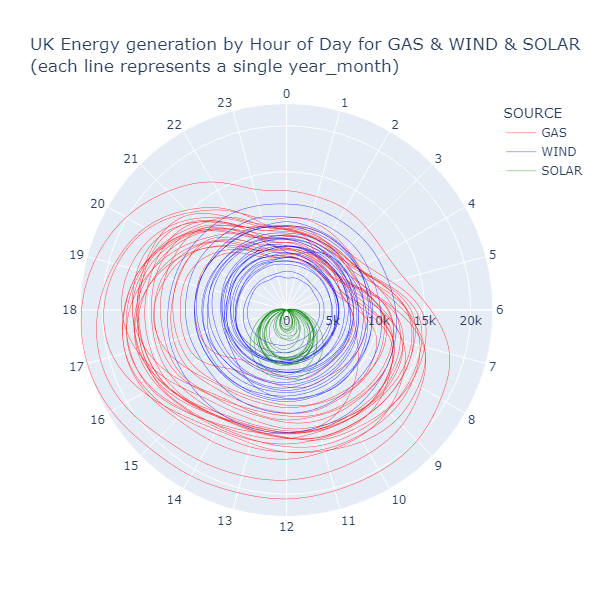

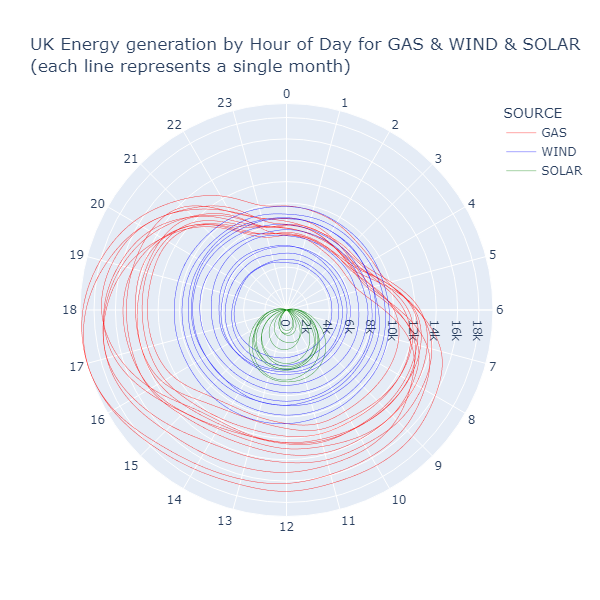

In [14]:
fig = cp.clock_plot(gen_mix, datetime_col='DATETIME', value_col='VALUE',
                    filters={'SOURCE':['GAS','WIND','SOLAR']},  
                    color='SOURCE', 
                    line_group='year_month',
                    height=600, width=600,
                    title_start='UK Energy generation',
                    color_discrete_sequence=['red', 'blue', 'green'],
                    category_orders={ 'SOURCE': ['GAS','WIND','SOLAR'] } )
fig = cp.clock_plot(gen_mix, datetime_col='DATETIME', value_col='VALUE',
                    filters={'SOURCE':['GAS','WIND','SOLAR']},  
                    color='SOURCE', 
                    line_group='month',
                    height=600, width=600,
                    title_start='UK Energy generation',
                    color_discrete_sequence=['red', 'blue', 'green'],
                    category_orders={ 'SOURCE': ['GAS','WIND','SOLAR'] } )

### Bins per day
Let's dig into solar in more detail by looking at it across seasons. Since we have half-hourly data we can switch from the default 24 bins per day (i.e. hourly) to 48 so that we plot one point per half-hour.

Unsurprisingly solar generates for fewer hours in winter than summer. However, even in summer it doesn't generate much between 6pm and 6am. Note that spring and summer look quite similar - this is because the definition of Spring is Apr-May and Summer is Jun-Aug, so the summer solstice (longest day) occurs right near the beginning of summer.

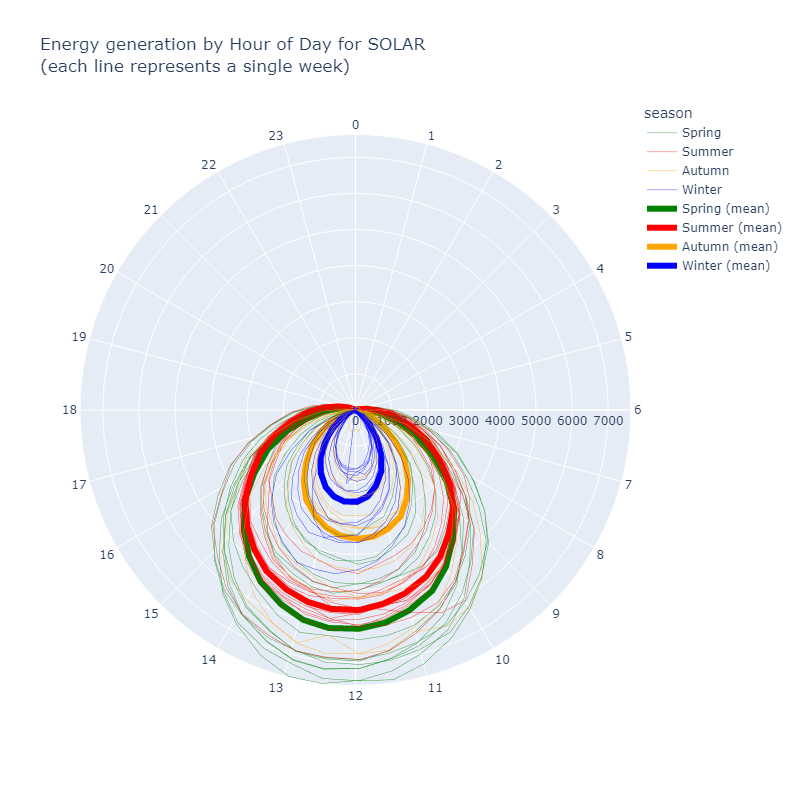

In [15]:
fig = cp.clock_plot(gen_mix, datetime_col='DATETIME', value_col='VALUE',
                    filters={'SOURCE':'SOLAR'},  
                    color='season', 
                    title_start='Energy generation',
                    line_group='week',
                    line_shape='linear',
                    aggregate={'season':'mean'},
                    bins_per_day=48)

### Using custom variables
We can create a custom season variable that is more centred on the solstices and feed that into the plot. That results in a plot that is more like what we would expect! Note that because we're using a custom variable and want the colors to align with our standard season colors we need to specify the category order.

In [16]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  2, 5))),
           ('spring', (date(Y,  2, 6),   date(Y,  5, 5))),
           ('summer', (date(Y,  5, 6),  date(Y,  8, 6))),
           ('autumn', (date(Y,  8, 7),  date(Y, 11, 5))),
           ('winter', (date(Y, 11, 6),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

In [17]:
gen_mix['season_accurate'] = gen_mix['DATETIME'].apply(get_season)

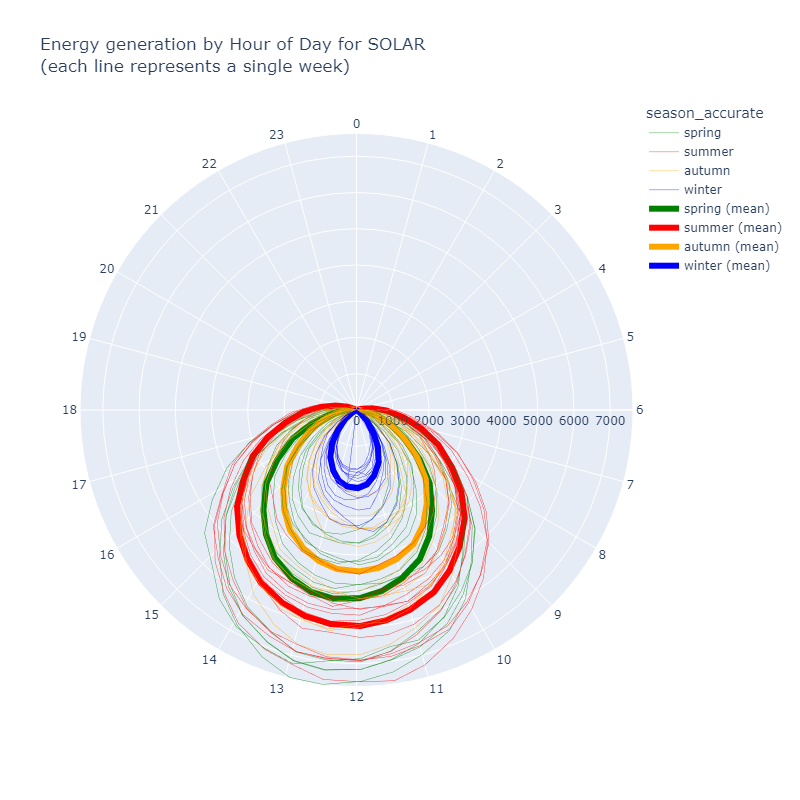

In [18]:
fig = cp.clock_plot(gen_mix, datetime_col='DATETIME', value_col='VALUE',
                    filters={'SOURCE':'SOLAR'},  
                    color='season_accurate', 
                    title_start='Energy generation',
                    line_group='week',
                    line_shape='linear',
                    aggregate={'season_accurate':'mean'},
                    category_orders={ 'season_accurate': ['spring','summer','autumn', 'winter'] },                     
                    bins_per_day=48)